In [ ]:
!nvidia-smi

Sun Aug 14 10:31:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

ADASYN+Tomek Link+Majority Voting Classifier, with evaluation

create voting classifier

In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/MalMem/
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 adasyn_tl_xgboost_imbalanced.ipynb
 adasyn_tl_xgboost_mm.ipynb
 clf_readcsv.py
 CNN_MalMem_balance
 CNN_MalMem_imbalance
 createCNN_Balanced.ipynb
 createCNN_Balanced.ipynb（副本）
 createCNN_Imbalanced.ipynb
'Dynamic Malware Analysis with Feature Engineering and Feature Learning.pdf'
 ensemble_major_imb.ipynb（iot）
 ensemble_major.ipynb
 ensemble_major.ipynb（副本）
 logs
 MalMem_Test_x.csv
 MalMem_Test_y.csv
 MalMem_Train_x.csv
 MalMem_Train_y.csv
 MalMem_x.csv
 MalMem_y.csv
'Malware Memory Analysis _ Datasets _ Canadian Institute for Cybersecurity _ UNB.mhtml'
 myXgb_adasyn_MalMem_imb.json
 myXgb_adasyn_MalMem.json
 Obfuscated-MalMem2022.csv
 Obfuscated-MalMem2022-excel.xlsx
'Obfuscated Malware Detection Using Deep Generative Model based on Global_Local Features - ScienceDirect.mhtml'
 output.docx
 train_attack_type_num.txt
 VotingClassifier_MalMem_balance.pkl
[

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 30 14:40:43 2021
Comparison using Majority Voting classifier and ensemble methods
using somote for oversampling
nsl-kdd dataset is 20%
@author: Administrator
"""
import pandas as pd
import numpy as np
import sys
#bagging and ensemble methods
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, zero_one_loss, \
    accuracy_score, classification_report, roc_auc_score
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from collections import Counter
import joblib

#other ensemble algorithm
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import HistGradientBoostingClassifier

#training dataset
x_train = pd.read_csv('MalMem_x.csv',header=None)
y_train = pd.read_csv('MalMem_y.csv',header=None)


#split dataset for train and test
train_x, test_x, train_Y, test_Y = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

print("train_x", train_x.head())
print("train_y", train_Y.head())
###
#testing dataset
#test_x = pd.read_csv('KDDTest_x_20.csv',header=None)
#test_Y = pd.read_csv('KDDTest_y_20.csv',header=None)
#print("test_x", test_x.head())
#print("test_y", test_Y.head())

train_Y = train_Y.values.ravel()
test_Y  = test_Y.values.ravel()
print("before oversampling \n", pd.Series(train_Y).value_counts())

#***apply SMOTE
#from collections import Counter
#from imblearn.over_sampling import SMOTE
#from imblearn.combine import SMOTETomek
#***only smote
#sm = SMOTE (sampling_strategy='auto', random_state=0)
#train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)
#print('smote dataset shape %s' % Counter(train_Y_sm))

"""
######--------------- RandomUnderSampler-------------------------
mean_class_size = int(pd.Series(train_Y).value_counts().sum()/4)
print("mean_class_size", mean_class_size)
ratio= {0: mean_class_size
        #'dos': mean_class_size,
        #'probe': mean_class_size,
        #'r2l': mean_class_size,
        #'u2r': mean_class_size
        }
# check if ratio para is still used
# print("before \n", pd.Series(train_Y).value_counts())
print('Original dataset shape %s' % Counter(train_Y))

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
train_x, train_Y = rus.fit_resample(train_x, train_Y)
print('now dataset shape %s' % Counter(train_Y))
"""
"""
# *******try using ADASYN on test dataset to make balance
# only 
from imblearn.over_sampling import ADASYN
ad = ADASYN (sampling_strategy='not majority', random_state=0)  #not majority
# train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)
train_x_ad, train_Y_ad = ad.fit_resample(train_x, train_Y)
print('adasyn dataset shape %s' % Counter(train_Y_ad))

#***Tomek Links
from imblearn.under_sampling import TomekLinks
sampling_strategy = "all"
tl = TomekLinks(sampling_strategy=sampling_strategy)
# x_res, Y_res = tl.fit_resample(train_x_sm, train_Y_sm)
x_res, Y_res = tl.fit_resample(train_x_ad, train_Y_ad)
print('Tomek Links dataset shape %s' % Counter(Y_res))
"""

#***smote+tomek
# smt = SMOTETomek(random_state=42)
# train_x_smt, train_Y_smt = smt.fit_resample(train_x, train_Y)
# print('after smote+tomek shape %s' % Counter(train_Y_smt))

# print("after SMOTE",  pd.Series(train_Y_smt).value_counts())
#sys.exit(0)
##-------------------------

#Try Majority Voting Method
def votingMethod():
    # log_clf = LogisticRegression(solver='lbfgs', max_iter=100)
    log_clf = LogisticRegression(solver='liblinear',max_iter=3000)
    # rnd_clf = RandomForestClassifier()
    svm_clf = SVC(probability=True)
    # nb_clf = GaussianNB()
    dt_clf = DecisionTreeClassifier(random_state=17)   #try random_state=1
    kn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    
    voting_clf=VotingClassifier(
        #estimators=[('lc',log_clf),('dt',dt_clf), ('nv', nb_clf), ('rf',rnd_clf), ('svm',svm_clf)],
        # voting='soft'
        #estimators=[('lc',log_clf),('dt',dt_clf), ('nv', nb_clf), ('kn',kn_clf), ('svm',svm_clf)],
        #estimators=[('lc',log_clf),('dt',dt_clf), ('nv', nb_clf), ('kn', kn_clf), ('svm',svm_clf)],
        #estimators=[('lc',log_clf),('dt',dt_clf), ('kn', kn_clf), ('svm',svm_clf)],  #original  
        estimators=[('lc',log_clf), ('dt',dt_clf), ('kn', kn_clf), ('svm',svm_clf)],  #decision tree
        voting='soft'
    )
    
    #evaluation of voting classifier
    #target_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
    target_names = ['Benign 0', 'Spyware 1', 'Ransomware 2', 'Trojan 3']
    #for clf in (log_clf, dt_clf, kn_clf, svm_clf, voting_clf):
    for clf in (log_clf, dt_clf, kn_clf, svm_clf, voting_clf): 
        #with and without smote
        #clf.fit(train_x, train_Y)   #without smote
        # clf.fit(train_x_sm, train_Y_sm)    #with SMOTE
        clf.fit(train_x, train_Y)    #with adasyn+tomek
        pred_Y = clf.predict(test_x)
        #cross_val_score(clf, X_train, y2_train, cv=3, scoring="accuracy")
        #print(clf.__class__.__name__,accuracy_score(y2_test, y_pred))
        results = confusion_matrix(test_Y, pred_Y, labels= clf.classes_)
        error = zero_one_loss(test_Y, pred_Y) 
        print("20% validation:", clf.__class__.__name__,accuracy_score(test_Y, pred_Y))
        print("20% error:", error)
        print("20% result: \n" , results)
        
        joblib.dump(clf, "VotingClassifier_MalMem_imbalance.pkl")

        yy = clf.predict_proba(test_x)
        rac = roc_auc_score(test_Y, yy, multi_class='ovr', average ='macro')  #Y_res
        print("ROC AUC Score:", rac)
        print(classification_report(test_Y, pred_Y, target_names=target_names))   #Y_res
        crpt=geometric_mean_score(test_Y, pred_Y)
        print(classification_report_imbalanced(test_Y, pred_Y, digits=4, target_names=target_names))  #Y_res
        print(f"The geometric mean is {crpt:.3f}") #Y_res
        
        
        
votingMethod()
######
"""
#try other ensembleMethods
def ensembleMethods():
    #ensemble methods
    dt_clf = DecisionTreeClassifier(random_state=17) 
    rnd_clf = RandomForestClassifier()
    ada_clf = AdaBoostClassifier(base_estimator=dt_clf,
                             n_estimators= 10,   #n_estimators= 500,
                             learning_rate=0.1,
                             random_state=17)
    
    gbc_clf = GradientBoostingClassifier(max_depth=None, n_estimators=10, learning_rate=0.1,random_state=17)
    hgbc_clf = HistGradientBoostingClassifier(max_depth=None, loss="categorical_crossentropy", learning_rate=0.1,random_state=17)
    etc_clf = ExtraTreesClassifier(max_depth=None, n_estimators=10, random_state=0)
    
    for clf in (dt_clf, rnd_clf, ada_clf, gbc_clf, hgbc_clf, etc_clf):  #test random forest algorithm
        clf.fit(train_x, train_Y)  #train model
        pred_Y = clf.predict(test_x)     #validation
        results = confusion_matrix(test_Y, pred_Y, labels= clf.classes_)
        print("validation:", clf.__class__.__name__,accuracy_score(test_Y, pred_Y))
        print(results)
        
ensembleMethods()
######
"""

train_x              0         1         2         3         4         5         6   \
31648 -0.414521  0.107713 -0.408853 -0.270007 -0.784783 -0.681461 -0.366478   
35376 -0.068333  0.484116 -1.182609 -0.407512 -0.818138 -1.066260 -0.406751   
56557 -0.241427  0.484116 -0.923460 -0.342490 -0.748395 -0.802478 -0.388464   
42854 -1.626181 -0.645094 -0.529937 -0.553809 -1.927970 -1.217187 -0.887763   
33410  0.104762  0.484116 -1.114600 -0.393448 -0.611940 -0.940144 -0.351684   

             7         8         9   ...        40        41        42  \
31648 -0.220915 -0.075494 -0.755363  ...  1.012450  0.194377 -0.518261   
35376 -0.326264 -0.069958 -0.841029  ...  0.273750  0.194377 -0.518261   
56557 -0.276448 -0.073746 -0.805025  ...  0.045105  0.194377 -0.518261   
42854 -0.438350 -0.099967 -2.042836  ... -0.511119 -4.849775 -1.401328   
33410 -0.315489 -0.067045 -0.742948  ... -0.404823  0.194377 -0.518261   

             43        44        45        46        47        48       

'\n#try other ensembleMethods\ndef ensembleMethods():\n    #ensemble methods\n    dt_clf = DecisionTreeClassifier(random_state=17) \n    rnd_clf = RandomForestClassifier()\n    ada_clf = AdaBoostClassifier(base_estimator=dt_clf,\n                             n_estimators= 10,   #n_estimators= 500,\n                             learning_rate=0.1,\n                             random_state=17)\n    \n    gbc_clf = GradientBoostingClassifier(max_depth=None, n_estimators=10, learning_rate=0.1,random_state=17)\n    hgbc_clf = HistGradientBoostingClassifier(max_depth=None, loss="categorical_crossentropy", learning_rate=0.1,random_state=17)\n    etc_clf = ExtraTreesClassifier(max_depth=None, n_estimators=10, random_state=0)\n    \n    for clf in (dt_clf, rnd_clf, ada_clf, gbc_clf, hgbc_clf, etc_clf):  #test random forest algorithm\n        clf.fit(train_x, train_Y)  #train model\n        pred_Y = clf.predict(test_x)     #validation\n        results = confusion_matrix(test_Y, pred_Y, labels= c

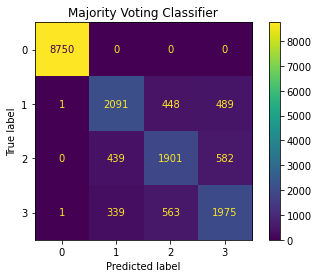

y: [[0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 ...
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
n_classes: 4


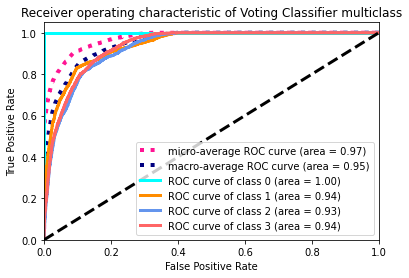

One-vs-One ROC AUC scores:
0.919718 (macro),
0.946283 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.951618 (macro),
0.967633 (weighted by prevalence),
0.973210(micro)


In [ ]:
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import confusion_matrix, zero_one_loss, classification_report, \
    plot_confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
import joblib

clf = joblib.load("VotingClassifier_MalMem_imbalance.pkl")

#metrics

#pred_y = clf.predict(test_x)
#results = confusion_matrix(test_Y, pred_y)
#error = zero_one_loss(test_Y, pred_y)

# print("20% result: \n" , results)
# print("20% error:", error)
# print("20% validation:", accuracy_score(test_Y, pred_y))
# print(classification_report(test_Y, pred_y, target_names=target_names))

# after tomek link 
pred_y = clf.predict(test_x)  #x_res
#results = confusion_matrix(test_Y, pred_y)   #Y_res

#error = zero_one_loss(test_Y, pred_y)   #Y_res
#target_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
target_names = ['Benign 0', 'Spyware 1', 'Ransomware 2', 'Trojan 3']
#print("20% result: \n" , results)
#print("20% error:", error)
#print("20% validation:", accuracy_score(test_Y, pred_y))   #Y_res
yy = clf.predict_proba(test_x)  #x_res

# yy = clf.decision_function(x_res)[:, 1]
#rac = roc_auc_score(test_Y, yy, multi_class='ovr', average ='macro')  #Y_res
#print("ROC AUC Score:", rac)
#print(classification_report(test_Y, pred_y, target_names=target_names))   #Y_res
#print(classification_report_imbalanced(test_Y, pred_y, target_names=target_names))  #Y_res
#print(f"The geometric mean is {geometric_mean_score(test_Y, pred_y):.3f}") #Y_res
#import seaborn as sns

#sns.set_context("poster")

# disp = plot_confusion_matrix(clf, test_x, test_Y, colorbar=False)  #x_res, Y_res

cm = confusion_matrix(test_Y, pred_y, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
_ = disp.ax_.set_title("Majority Voting Classifier")
plt.show()
# ***plot confusion matrix
# plt.matshow(results, cmap=plt.cm.gray)
# plt.show()

"""
#whole test data
w_pred_y = clf.predict(w_test_x)
w_results = confusion_matrix(w_test_Y, w_pred_y)
w_error = zero_one_loss(w_test_Y, w_pred_y)
print("w_result: \n" , w_results)
print("w_error:", w_error)
print("w_validation:", accuracy_score(w_test_Y, w_pred_y))
print(classification_report(w_test_Y, w_pred_y, target_names=target_names))
"""

# plot roc curve
y = label_binarize(test_Y, classes=[0, 1, 2, 3])  #Y_res
n_classes = y.shape[1]

print("y:", y)
print("n_classes:", n_classes)

lw = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # fpr[i], tpr[i], _ = roc_curve(Y_res[:, i], y[:, i])
    # fpr[i], tpr[i], threshold = roc_curve(y[:, i], yy[:, i], pos_label=0)
    fpr[i], tpr[i], threshold = roc_curve(y[:, i], yy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), yy.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)



colors = cycle(["aqua", "darkorange", "cornflowerblue", "#FF6666"])  #, "green", "yellow", "slategray", "blueviolet"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic of Voting Classifier multiclass")
plt.legend(loc="lower right")
plt.show()


# compute roc_auc_score
# y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(test_Y, yy, multi_class="ovo", average="macro")  #Y_res
weighted_roc_auc_ovo = roc_auc_score(
    test_Y, yy, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(test_Y, yy, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    test_Y, yy, multi_class="ovr", average="weighted"
) #Y_res
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence),\n{:.6f}"   #leon
    "(micro)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr, roc_auc["micro"])  #leon
    #"(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)